In [3]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras.models import Sequential
from keras import regularizers,layers
import keras.backend as K
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = ['Dataset/HandOutlines_TRAIN', 'Dataset/HandOutlines_TEST']
full_train_data = pd.read_csv(data[0], header = None)
full_test_data = pd.read_csv(data[1], header = None)

train_dataset = full_train_data.iloc[:,range(1,full_train_data.shape[1])] #traindatawithoutlabel
label_test = full_train_data.iloc[:,0] #trainlabel

test_dataset = full_test_data.iloc[:,range(1,full_test_data.shape[1])] #testdatawithoutlabel
label_train = full_test_data.iloc[:,0] #testlabel

train_dataset = train_dataset.values
label_train = label_train.values

test_dataset=test_dataset.values
label_test=label_test.values

test_data = np.expand_dims(test_dataset, axis=2)
train_dataset = np.expand_dims(train_dataset, axis=2)

In [128]:
file = open('Orig_wafer.pkl', 'wb')

orig_info = {}
orig_info['X_train'] = np.squeeze(test_data)
orig_info['y_train'] = label_train
orig_info['X_test'] = np.squeeze(train_dataset)
orig_info['y_test'] = label_test

# dump information to that file
pickle.dump(orig_info, file)

In [6]:
encoding_dim = 32
window_length = train_dataset.shape[1]
epochs = 15
test_samples = train_dataset.shape[0]

In [9]:
input_window = Input(shape=(window_length,1))
x = Conv1D(32, 7, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(7, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(9, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 1, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(9)(x) # 6 dims
x = Conv1D(32, 1, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(7)(x) # 10 dims
decoded = Conv1D(1, 2, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(test_data, test_data,
                epochs=120,
                batch_size=1024,
                shuffle=True,
                validation_data=(train_dataset, train_dataset))





decoded_stocks = autoencoder.predict(train_dataset)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2709, 1)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2709, 32)          256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 387, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 387, 1)            97        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 43, 1)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 43, 1)             2         
_________________________________________________________________
up_sampling1d_5 (UpSampling1 (None, 387, 1)            0   

Epoch 64/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6623 - val_loss: 0.6618
Epoch 65/120
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6618 - val_loss: 0.6613
Epoch 66/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6613 - val_loss: 0.6608
Epoch 67/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6608 - val_loss: 0.6604
Epoch 68/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6604 - val_loss: 0.6599
Epoch 69/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6599 - val_loss: 0.6594
Epoch 70/120
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6594 - val_loss: 0.6589
Epoch 71/120
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6589 - val_loss: 0.6585
Epoch 72/120
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6585 - val_loss: 0.6580
Epoch 73/120
1000/1000 [==============================] - 6s 6ms

Conv Auto Encoder Reconstruction error : 0.36162702142010433

In [148]:
print(decoded_stocks.shape,train_dataset.shape)
# print(np.absolute(x_test_deep[0]))
# print(np.absolute(decoded_stocks[0]))
# print(len(x_test_deep[0]))
def repr_error(actual, predicted):
    final_err = 0
    for i in range(len(actual)):
        err = np.sum(np.absolute(np.absolute(actual[i]) - np.absolute(predicted[i])))
        err = err / len(actual[i])
        final_err += err
    final_err = final_err / len(actual)
    return final_err
# final_test = np.sum(np.absolute(np.absolute(x_test_deep[0]) - np.absolute(decoded_stocks[0])))
# print(final_test/150)
print(repr_error(train_dataset, decoded_stocks))

(36, 343, 1) (36, 343, 1)
0.4812057950921338


In [188]:
import pickle
# open a file, where you ant to store the data
file = open('Conv_wafer.pkl', 'wb')

# dump information to that file
pickle.dump(autoencoder, file)

In [162]:
autoencoder.layers[4].name = "embed_0"
layer_output=autoencoder.get_layer('embed_0').output
intermediate_model=Model(inputs=autoencoder.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(train_dataset)


In [163]:
latent_test = np.squeeze(intermediate_prediction)


In [164]:
intermediate_prediction=intermediate_model.predict(test_data)
latent_train = np.squeeze(intermediate_prediction)


In [165]:
file = open('Latent_toesegmentation2.pkl', 'wb')

latent_info = {}
latent_info['X_train'] = latent_train
latent_info['y_train'] = label_train
latent_info['X_test'] = latent_test
latent_info['y_test'] = label_test

# dump information to that file
pickle.dump(latent_info, file)

(343, 1)


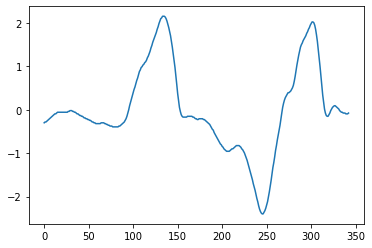

In [161]:
print(train_dataset[0].shape)
plt.plot(train_dataset[15])
plt.show()

(7,)


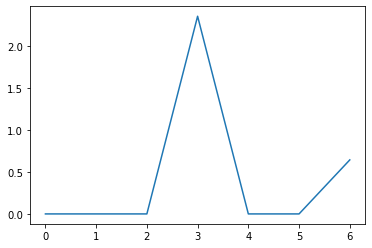

In [158]:
# print(latent_train[0])
print(latent_train[0].shape)
plt.plot(latent_train[15])
plt.show()

In [104]:
file = open('Latent_wafer.pkl', 'wb')
# dump information to that file
pickle.dump(latent_info, file)